# Optical Wave Gauging for Google Colab

by Daniel Buscombe, daniel.buscombe@nau.edu

This notebook is part of https://github.com/dbuscombe-usgs/OpticalWaveGauging_DNN


### Estimate a wave height per image within a folder of images

Workflow:

1. Write a configuration file - this is how you interact with OWG functions
2. Download the data and model weights
3. Define the model
4. Generate test images and associated wave heights from the downloaded imagery
5. Use the model to estimate wave height for each image
6. Make plots



Import libraries

In [1]:
import os, json, zipfile, requests
import numpy as np 
from imageio import imread
from sklearn.model_selection import train_test_split
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

This notebook assumes you are in Google Colab. Therefore, switch to Tensorflow 2 and verify by printing the version, which should say '2.X.X' where X can be any number

In [3]:
#%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.5.0


Import the tensorflow/keras libraries we need to define and use the model

In [4]:
from tensorflow.keras.metrics import mean_absolute_error
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.preprocessing import image

Write the configuration file using the magic command 'writefile'

In [6]:
!rm config_test.json

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
%%writefile config_testMC17trial5.json
{
  "samplewise_std_normalization" : true,
  "samplewise_center"  : true,
  "weights_path" : "C:/njc/src/SSF/OWG/mcy_H_weights_trial5_13batch.best.nearshore.hdf5",
  "input_csv_file"     : "C:/njc/src/SSF/OWG/OWG_records/Trial3/mcyv22017(30trial3).csv", 
  "category"           : "H",
  "im_size"            : 512,
  "image_direc"        : "C:/njc/src/mcyimgs/2017_imgprep3/view2",
  "prc_lower_withheld": 0,
  "prc_upper_withheld": 0,
  "file_ext": "jpg"  
}

Writing config_testMC17trial5.json


Open the config file and read values into workspace. This might seem like a long-winded way of doing things -- and it is --- but this is how things are set up in the command line python scripts version of this workflow in `https://github.com/dbuscombe-usgs/OpticalWaveGauging_DNN/test_OWG_folder.py` so it is maintained here for consistency

In [6]:
with open('C:/njc/src/SSF/OWG/config_testMC17trial5.json') as f:    
    config = json.load(f)

# config variables
im_size    = int(config["im_size"])
category = config["category"] 
input_csv_file = config["input_csv_file"]   
weights_path = config["weights_path"]
samplewise_std_normalization = config["samplewise_std_normalization"]
samplewise_center = config["samplewise_center"]  
image_direc = config["image_direc"]    
IMG_SIZE = (im_size, im_size) 

Set model and print a summary

In [7]:
base_model = MobileNet(input_shape =  (IMG_SIZE[0], IMG_SIZE[1],1), include_top = False, weights = None)			
OWG = Sequential()
OWG.add(BatchNormalization(input_shape = (IMG_SIZE[0], IMG_SIZE[1],1)))
OWG.add(base_model)
OWG.add(BatchNormalization())
OWG.add(GlobalAveragePooling2D())
OWG.add(Dropout(0.5)) 
OWG.add(Dense(1, activation = 'linear' )) 

OWG.compile(optimizer = 'rmsprop', loss = 'mse')
OWG.load_weights(weights_path)
OWG.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 512, 512, 1)       4         
_________________________________________________________________
mobilenet_1.00_512 (Function (None, 16, 16, 1024)      3228288   
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 1024)      4096      
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 3,233,413
Trainable params: 3,209,475
Non-trainable params: 23,938
_________________________________________

Generate a pandas datafrom from csv file

In [8]:
def get_and_tidy_df(base_dir, input_csv_file, image_dir, category):
    df = pd.read_csv(os.path.join(base_dir, input_csv_file))
    df['path'] = df['id'].map(lambda x: os.path.join(base_dir,
                                                        image_dir,'{}'.format(x))) #+".jpg"

    df = df.rename(index=str, columns={" H": "H", " T": "T"})   

    if category == 'H':
        mean = df['H'].mean() 
        div = df['H'].std() 
        df['zscore'] = df['H'].map(lambda x: (x-mean)/div)
    elif category == 'T':
        mean = df['T'].mean() 
        div = df['T'].std() 
        df['zscore'] = df['T'].map(lambda x: (x-mean)/div)			
    else:
        print("Unknown category: "+str(category))
        print("Fix config file, exiting now ...")
        sys.exit()

    df.dropna(inplace = True)
    try:
        df = df.sort_values(by='time', axis=0)
    except:
        df = df.sort_values(by='id', axis=0)

    df['index1'] = df.index

    return df

Get a dataframe that we will pass to our image batch generator

In [9]:
df = get_and_tidy_df(os.path.normpath(os.getcwd()), input_csv_file, image_direc, category)

Get a keras image data generator with no augmentation but scale the images according to samplewise_std_normalization and samplewise_center

In [10]:
def im_gen_noaug(samplewise_std_normalization, samplewise_center):
    return ImageDataGenerator(samplewise_center=samplewise_center,  
							      samplewise_std_normalization=samplewise_std_normalization, 
							      horizontal_flip = False, 
							      vertical_flip = False, 
							      height_shift_range = 0, 
							      width_shift_range = 0, 
							      rotation_range = 0,  
							      shear_range = 0, 
							      fill_mode = 'reflect', 
							      zoom_range= 0) 

Function to make a generator from a dataframe	

In [11]:
def gen_from_def(IMG_SIZE, df, image_dir, category, im_gen):

    gen = im_gen.flow_from_dataframe(dataframe=df,
                                  directory=os.getcwd()+os.sep+image_dir,
                                  x_col="path",
                                  y_col=category,
                                  target_size=IMG_SIZE,
                                  batch_size=len(df),
                                  color_mode = 'grayscale',
                                  shuffle=False,
                                  class_mode='raw')

    ex_X, ex_Y = next(gen)
    return ex_X, ex_Y

Get the test set of images `test_X` and associated wave heights `test_Y`

In [12]:
# call the utils.py function im_gen_noaug    
im_gen = im_gen_noaug(samplewise_std_normalization, samplewise_center)

# call the utils.py function gen_from_def
test_X, test_Y = gen_from_def(IMG_SIZE, df, image_direc, category, im_gen)

Found 245 validated image filenames.


Use the model to estimate wave height from every image (that number can be anything from 1 to the length of `test_X`)

In [13]:
print ("[INFO] Predicting ...")     												    
pred_Y = np.squeeze(OWG.predict(test_X, batch_size = 122, verbose = True))    

[INFO] Predicting ...
3/3 [==============================] - 7s 452ms/step


Make a plot of observed versus estimated wave height

[INFO] Plotting ...


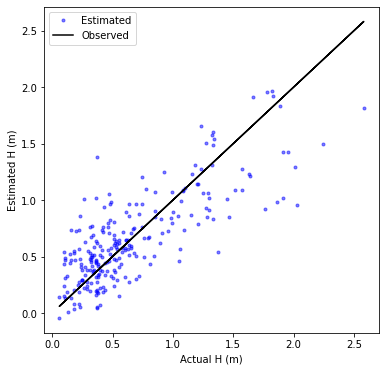

In [14]:
print ("[INFO] Plotting ...")     												        
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y, pred_Y, 'b.', alpha=0.5, label = 'Estimated')
ax1.plot(test_Y, test_Y, 'k-', label = 'Observed')
ax1.legend()
if category=='H':
   ax1.set_xlabel('Actual H (m)')
   ax1.set_ylabel('Estimated H (m)')
else:
   ax1.set_xlabel('Actual T (s)')
   ax1.set_ylabel('Estimated T (s)')    
plt.show() 

Make a plot showing 16 random images, their true wave heights and their estimated height

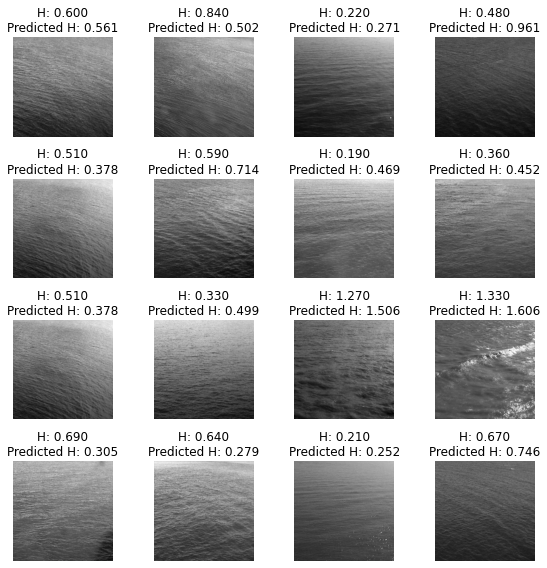

In [15]:
rand_idx = np.random.choice(range(test_X.shape[0]), 16)
fig, m_axs = plt.subplots(4, 4, figsize = (8, 8))
for (idx, c_ax) in zip(rand_idx, m_axs.flatten()):
  c_ax.imshow(test_X[idx, :,:,0], cmap = 'gray')
  if category == 'H':
      c_ax.set_title('H: %0.3f\nPredicted H: %0.3f' % (test_Y[idx], pred_Y[idx]))
  else:
      c_ax.set_title('T: %0.3f\nPredicted T: %0.3f' % (test_Y[idx], pred_Y[idx]))
  
  c_ax.axis('off')

plt.tight_layout()

## Get error statistics

In [16]:
#r^2 value

from scipy.stats import linregress

def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return r_value**2

In [17]:
r_value = rsquared(test_Y, pred_Y)
# round r^2 to the number of decimal places that is present in the OWG_train mean absolute error
print (round(r_value, 5))

0.61868


In [18]:
def mape(actual, pred): 
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [19]:
print (type(test_Y))
errorper = mape(test_Y, pred_Y)
print (errorper)

<class 'numpy.ndarray'>
53.275326189220515
